## Exploratory Data Analysis

We explore our working features and labels here.

#### Research Questions (final?)

1. Build multi-label classifier: test importance of parameter and preprocessing steps on model performance. Build baseline
and analyse why preprocessing is important for model performance (e.g. proper label encoding -> ordering/relations)

2. Model explainability: in general DL models outperform ML models with the tradeoff of explainability, inspired by our
masters thesis we will perfrom model distillation from DL high performing model to ML high performing model in order to
analyse feature importance.

In [1]:
import os
import sys

sys.dont_write_bytecode = True
root_dir = os.path.abspath(os.pardir)
if root_dir not in sys.path:
    sys.path.append(root_dir)

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from configs.constants import *
from scripts.data import *

In [2]:
metafile = '../data/results/complete_metadata_mapping_2.csv'
data_dir_folder_path = os.path.abspath(os.path.join(root_dir, DATA_DIR_FOLDER))
data_dir_path = os.path.abspath(os.path.join(data_dir_folder_path, DATA_DIR))

In [40]:
meta_df = pd.read_csv(metafile)
meta_df['dx_codes'] = meta_df['dx_codes'].map(json.loads)

Descriptives

In [41]:
meta_df[['n_sig', 'fs', 'n_samples', 'age', 'sex']].describe()

,n_sig,fs,n_samples,age
count,45151.0,45151.0,45151.0,45097.000000
mean,12.0,500.0,5000.0,58.208462
std,0.0,0.0,0.0,19.688251
min,12.0,500.0,5000.0,0.000000
25%,12.0,500.0,5000.0,48.000000
50%,12.0,500.0,5000.0,61.000000
75%,12.0,500.0,5000.0,72.000000
max,12.0,500.0,5000.0,89.000000


Null analysis

In [42]:
meta_df.isnull().sum()

record          1
hea_path        0
record_path     0
n_sig           1
fs              1
n_samples       1
age            55
sex             0
dx_codes        0
dtype: int64

#### Target Label analysis

In [43]:
labels = load_labels(data_dir_folder_path, 'ConditionNames_SNOMED-CT.csv')

Cardinality of se $L, |L| = 55$ we are working with (possibly coocurring) heart conditions.

In [44]:
labels['Snomed_CT'].nunique()

55

**important**: there might be linear relationships across the sub-groups of heart conditions

e.g. 1st degree venticular block is less serious than 2nd degree block.

In [45]:
labels

,Acronym Name,Full Name,Snomed_CT
0,1AVB,1 degree atrioventricular block,270492004
1,2AVB,2 degree atrioventricular block,195042002
2,2AVB1,2 degree atrioventricular block(Type one),54016002
3,2AVB2,2 degree atrioventricular block(Type two),28189009
4,3AVB,3 degree atrioventricular block,27885002
...,...,...,...
58,SVT,Supraventricular Tachycardia,426761007
59,AT,Atrial Tachycardia,713422000
60,AVNRT,Atrioventricular Node Reentrant Tachycardia,233896004
61,AVRT,Atrioventricular Reentrant Tachycardia,233897008


coocurance of conditions -> pretty broad range but more conditions are rarer and rarer

In [47]:
meta_df['dx_codes'].apply(lambda x: len(x)).value_counts()

dx_codes
1     22178
2     11871
3      5913
4      2902
5      1423
6       588
7       188
8        65
9        15
10        7
12        1
11        1
Name: count, dtype: int64

DX Codes are not conditions -> analysis of present conditions provided against input label mapping

In [48]:
label_codes = labels['Snomed_CT'].unique()
dx_codes = np.concat(meta_df['dx_codes'].map(np.array).to_numpy())
dx_codes_set = np.unique(dx_codes)

input dataset works with 94 snomed CT codes -> from our data provided mapping we only have 55

In [49]:
print(label_codes.shape)
print(dx_codes_set.shape)

(55,)
(94,)


question: how many of the present label codes (label metadata intersection) are present rows in the working patient dataframe

In [52]:
common = np.intersect1d(label_codes, dx_codes_set)
common.shape

# 51 common snomed CT codes

(51,)

filtering rows with common subset

### X analyses

patient metadata

In [10]:
meta_df['age'].max()

np.float64(89.0)

c:\Users\samue\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\samue\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\samue\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\samue\App

<Axes: xlabel='age', ylabel='Count'>

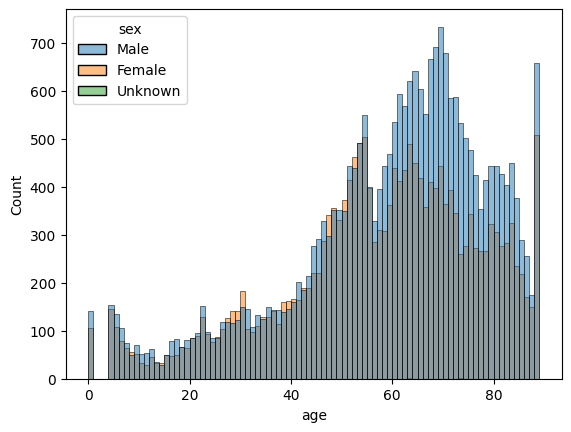

In [11]:
sns.histplot(meta_df, x='age', hue='sex', bins=89)

distribution shifted to the right -> to be expected as CVD patients are usually older, we do have some younger patients
as well though